# Indentifying Stress Factors in Rainbow Trouts - ML

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [86]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

SEED = 32

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Data - USDA
Performing basic cleanup and organization.
* Fishes belonging to the following categories: Control(con), Crowded(cro), High Salinity(hs), High temperature(ht), Low Temperature(lt) and Reused Water(rw).
* The dataset was transposed and renamed to become organized.
* The columns are the transcripts obtained from the fish. The prefix is the gene whereas, the suffix is the transcript number.

In [4]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
data = pd.read_excel(dataPath)

data.columns = columns
data = data.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
data = data.assign(tank = tankColums)

print(data.shape)
data.head()

(40, 125909)
CPU times: user 21 s, sys: 261 ms, total: 21.3 s
Wall time: 21.4 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [5]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, con0 to rw5
Columns: 125909 entries, 4ebp2_1 to tank
dtypes: float64(125908), object(1)
memory usage: 38.4 MB


In [6]:
# Removing columns with mean 0
meanZeroCols = data.iloc[:,:-1].mean() == 0

meanZeroCols = meanZeroCols[meanZeroCols==True].index.tolist()
print(f"Number of columns with just 0: {len(meanZeroCols)}\nTotal Number of columns: {data.shape[1]}")
print(f"This is {(len(meanZeroCols)/data.shape[1])*100: .2f}% of all columns")
# data[meanZeroCols].mean()

Number of columns with just 0: 30013
Total Number of columns: 125909
This is  23.84% of all columns


In [7]:
data = data.loc[:, (data!=0).any(axis=0)]
data.head()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_6,aakb1_7,aakb1_8,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.000000,0.0,5.631537,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.000000,0.0,6.048805,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,4.817612,0.0,7.248526,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.000000,0.0,7.837344,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.000000,0.0,5.786782,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


## Common Features

In [8]:
commonFeatures = []
with open("./primaryColumnList.txt", "r") as f:
  for line in f:
    commonFeatures.append(str(line.strip()))

In [9]:
targetNames = ['control','crowded', 'high salinity', 'high temp', 'low temp', 'resued water']

## Data - UMD

In [10]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

CPU times: user 39.3 s, sys: 397 ms, total: 39.7 s
Wall time: 39.9 s


In [11]:
%%time

colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)
dataUMD.rename(columns={'GeneExp':'Group'}, inplace=True)
print(dataUMD.shape)

(72, 125910)
CPU times: user 414 ms, sys: 25.6 ms, total: 439 ms
Wall time: 438 ms


In [12]:
dataUMD.head()

idx,Group,DAY,4ebp2,5ntc,aacs,aadac,aadacl4,aagab,aakb1_1,aakb1_2,...,zwilch_1,zwilch_2,zwilch_3,zwilch_4,zyg11,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3
0,CTRL,Day 7,20.392085,5.01189,2.244453,0.783542,0.474814,1.52711,32.438119,0,...,0,1.508154,0.302833,0.484558,9.294329,4.216087,0,1.423811,1.684077,1.661112
1,CTRL,Day 1,27.289734,7.310938,2.958239,1.270043,0.841218,3.128293,43.348779,0,...,0.278156,0.607265,0.017884,0.008943,10.089153,5.1805,0.843944,2.746311,2.820902,3.003989
2,CTRL,Day 7,24.278669,6.795036,2.367945,0.872521,0.780329,1.737497,37.117946,0,...,0,1.419542,0.42495,0.493886,9.274609,4.752717,0,2.029312,1.88996,1.950927
3,CTRL,Day 3,20.71429,10.404623,2.90694,1.307162,0.486661,3.026489,28.212887,0,...,0.007786,0.558591,0.333669,0.411287,9.13582,7.467661,0.015257,2.265504,2.312579,2.436152
4,CTRL,Day 1,23.821724,6.310578,2.060801,1.290215,1.001488,2.70031,35.728362,0,...,0.591635,1.521557,0.036851,0.00737,8.732718,2.68104,1.912857,1.794056,1.98408,1.889068


In [13]:
dataUMD['Group'].value_counts()

Group
CTRL    36
HEAT    36
Name: count, dtype: int64

In [14]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

commonFeaturesUMD = list(set(umdDataFeatures) & set(commonFeatures))

print(f"{len(commonFeatures)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(commonFeaturesUMD)*100/len(commonFeatures):.2f}% of the training data feature set (USDA)")

54.86% of UMD data feature set
71.48% of the training data feature set (USDA)
CPU times: user 10.1 ms, sys: 876 µs, total: 10.9 ms
Wall time: 10.8 ms


In [15]:
%%time
dataUMD.replace({'CTRL':0, 'HEAT':1}, inplace=True)

CPU times: user 2.8 s, sys: 67.7 ms, total: 2.87 s
Wall time: 2.87 s


---

In [16]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(4, 2))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

# Primary Feature Analysis

## Binary Classification Only

In [92]:
%%time
# Retraining Model on entire USDA data but just for control and heat groups

dataModel = data.loc[:,commonFeaturesUMD+['tank']].copy()
dataModelBC = dataModel[(dataModel['tank'] == 'con') | (dataModel['tank'] == 'ht')]
dataModelBC.loc[:,:] = dataModelBC.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})
xdata, ydata = dataModelBC.loc[:, commonFeaturesUMD], dataModelBC.iloc[:,-1]
ydata = np.array(ydata.astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

CPU times: user 1.88 s, sys: 42.3 ms, total: 1.93 s
Wall time: 1.95 s


In [93]:
# Testing on UMD data
xtest, ytest = dataUMD.loc[:, commonFeaturesUMD], dataUMD.iloc[:, 0]

### Naive Bayes

In [94]:
bnb = BernoulliNB()
bnb.fit(xdata_sca, np.array(ydata).astype(int))

BernoulliNB()

In [95]:
%%time
# xtest, ytest 
xtest_sca = sca.transform(xtest)
ypred = bnb.predict(xtest_sca)

CPU times: user 639 ms, sys: 1.1 s, total: 1.74 s
Wall time: 239 ms


              precision    recall  f1-score   support

         CON       0.70      0.64      0.67        36
        HEAT       0.67      0.72      0.69        36

    accuracy                           0.68        72
   macro avg       0.68      0.68      0.68        72
weighted avg       0.68      0.68      0.68        72



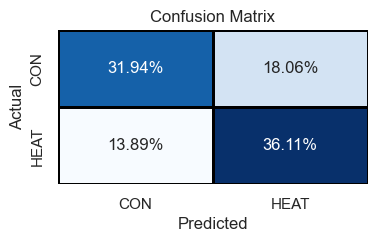

In [96]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

### Logistic Regression

In [97]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xdata_sca, ydata.astype(int))

CPU times: user 29.6 s, sys: 40.9 s, total: 1min 10s
Wall time: 9.19 s


LogisticRegression(random_state=32)

In [98]:
%%time
# xtest, ytest 
xtest_sca = sca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

CPU times: user 570 ms, sys: 818 ms, total: 1.39 s
Wall time: 200 ms


              precision    recall  f1-score   support

         CON       0.63      0.92      0.75        36
        HEAT       0.85      0.47      0.61        36

    accuracy                           0.69        72
   macro avg       0.74      0.69      0.68        72
weighted avg       0.74      0.69      0.68        72



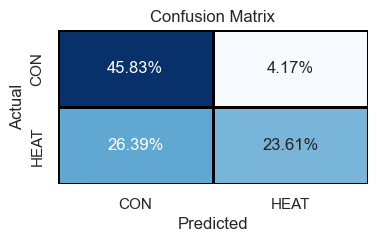

In [99]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

In [107]:
acc_, f1_ = [],[]
for c_ in tqdm(np.arange(0.001,1,0.01)):
    logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet', C=c_, solver='saga', l1_ratio=0.5)
    logRes_clf.fit(xdata_sca, ydata)
    
    ypred = logRes_clf.predict(xtest_sca)
    
    rep_ = classification_report(ytest,ypred,output_dict=True, zero_division=0)
    acc_.append(rep_['accuracy'])
    f1_.append(rep_['macro avg']['f1-score'])
    
    

100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


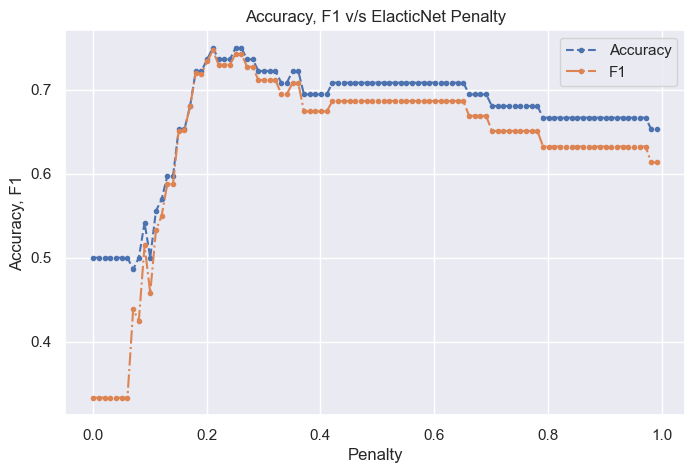

In [109]:
plt.figure(figsize=(8,5), dpi = 100)
plt.plot(np.arange(0.001,1,0.01), acc_, '.--', label='Accuracy')
plt.plot(np.arange(0.001,1,0.01), f1_, '.-.', label='F1')
plt.legend()
plt.title("Accuracy, F1 v/s ElacticNet Penalty")
plt.xlabel("Penalty")
plt.ylabel("Accuracy, F1")
plt.show()

In [112]:
%%time
logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)
logRes_clf.fit(xdata_sca, ydata.astype(int))

CPU times: user 467 ms, sys: 6.24 ms, total: 473 ms
Wall time: 471 ms


LogisticRegression(C=0.21, l1_ratio=0.5, penalty='elasticnet', random_state=32,
                   solver='saga')

In [113]:
%%time
# xtest, ytest 
xtest_sca = sca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

CPU times: user 127 ms, sys: 7.24 ms, total: 134 ms
Wall time: 151 ms


              precision    recall  f1-score   support

         CON       0.70      0.86      0.78        36
        HEAT       0.82      0.64      0.72        36

    accuracy                           0.75        72
   macro avg       0.76      0.75      0.75        72
weighted avg       0.76      0.75      0.75        72



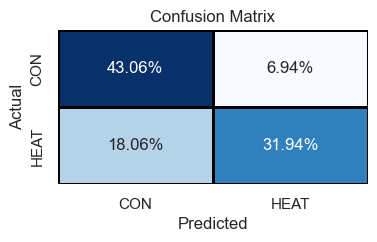

In [114]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

### SVM

In [183]:
%%time
# Linear Kernel
svm_clf.fit(xdata_sca, ydata)

CPU times: user 482 ms, sys: 310 ms, total: 792 ms
Wall time: 105 ms


SVC(kernel='linear')

In [184]:
%%time
xtest_sca = sca.transform(xtest)
ypred = svm_clf.predict(xtest_sca)

CPU times: user 970 ms, sys: 490 ms, total: 1.46 s
Wall time: 194 ms


              precision    recall  f1-score   support

         CON       0.67      0.86      0.76        36
        HEAT       0.81      0.58      0.68        36

    accuracy                           0.72        72
   macro avg       0.74      0.72      0.72        72
weighted avg       0.74      0.72      0.72        72



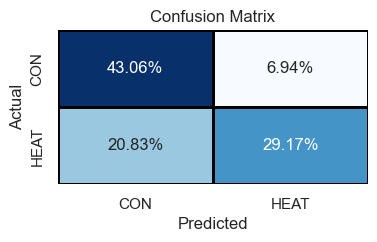

In [185]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

CPU times: user 547 ms, sys: 30 ms, total: 577 ms
Wall time: 92.1 ms


              precision    recall  f1-score   support

         CON       0.50      1.00      0.67        36
        HEAT       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



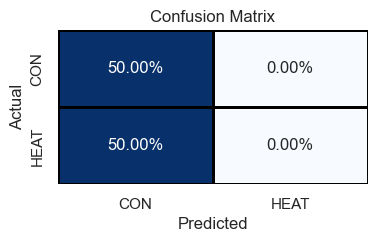

In [187]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

In [188]:
%%time
# Sigmoid Kernel
svm_clf = SVC(kernel='sigmoid')
svm_clf.fit(xdata_sca, ydata)

ypred = svm_clf.predict(xtest_sca)

CPU times: user 301 ms, sys: 17.6 ms, total: 319 ms
Wall time: 63.2 ms


              precision    recall  f1-score   support

         CON       0.58      0.78      0.67        36
        HEAT       0.67      0.44      0.53        36

    accuracy                           0.61        72
   macro avg       0.62      0.61      0.60        72
weighted avg       0.62      0.61      0.60        72



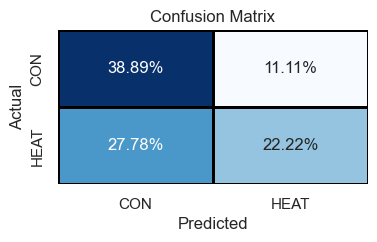

In [189]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

In [190]:
%%time
acc_, f1_ = [],[]
for deg_ in range(1, 16):
    svm_clf = SVC(kernel='poly', degree=deg_)
    svm_clf.fit(xdata_sca, ydata)
    
    ypred = svm_clf.predict(xtest_sca)
    
    rep_ = classification_report(ytest,ypred,output_dict=True, zero_division=0)
    acc_.append(rep_['accuracy'])
    f1_.append(rep_['macro avg']['f1-score'])

CPU times: user 3.29 s, sys: 189 ms, total: 3.48 s
Wall time: 481 ms


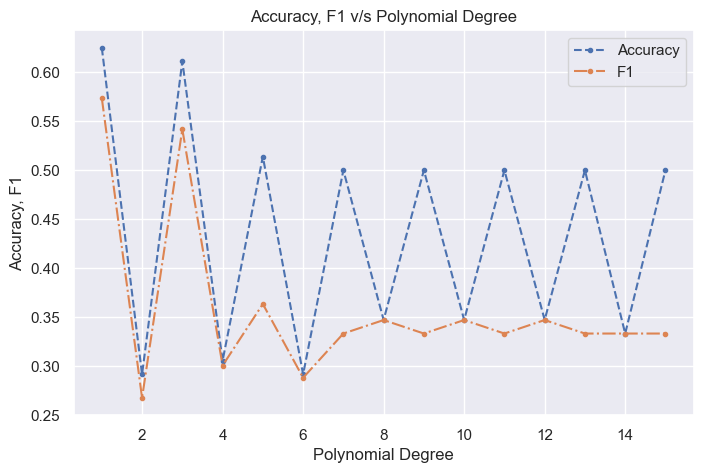

In [191]:
plt.figure(figsize=(8,5), dpi = 100)
plt.plot(range(1,16), acc_, '.--', label='Accuracy')
plt.plot(range(1,16), f1_, '.-.', label='F1')
plt.legend()
plt.title("Accuracy, F1 v/s Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy, F1")
plt.show()

In [118]:
%%time
acc_, f1_ = [],[]
for c_ in tqdm(np.arange(0.001,1,0.01)):
    svm_clf = SVC(kernel='rbf', C=c_)
    svm_clf.fit(xdata_sca, ydata)
    
    ypred = svm_clf.predict(xtest_sca)
    
    rep_ = classification_report(ytest,ypred,output_dict=True, zero_division=0)
    acc_.append(rep_['accuracy'])
    f1_.append(rep_['macro avg']['f1-score'])
    

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.35it/s]

CPU times: user 34.3 s, sys: 5.47 s, total: 39.8 s
Wall time: 5.17 s


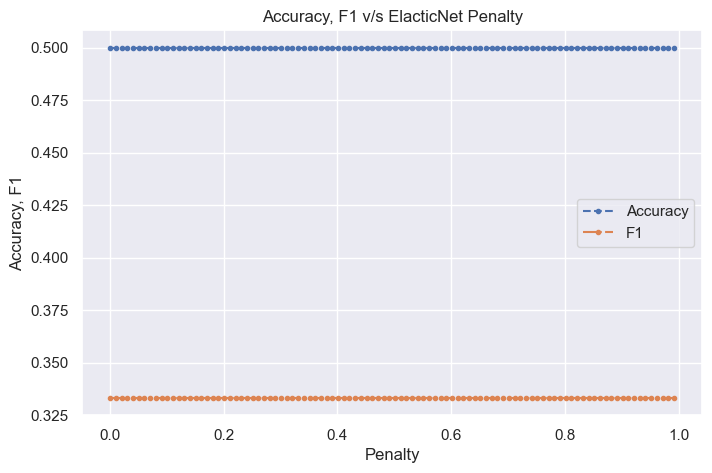

In [119]:
plt.figure(figsize=(8,5), dpi = 100)
plt.plot(np.arange(0.001,1,0.01), acc_, '.--', label='Accuracy')
plt.plot(np.arange(0.001,1,0.01), f1_, '.-.', label='F1')
plt.legend()
plt.title("Accuracy, F1 v/s ElacticNet Penalty")
plt.xlabel("Penalty")
plt.ylabel("Accuracy, F1")
plt.show()

### Decision Tree

In [62]:
%%time
dt_clf = DecisionTreeClassifier()

dt_clf.fit(xdata_sca, ydata)

CPU times: user 70.1 ms, sys: 3.85 ms, total: 74 ms
Wall time: 71.4 ms


DecisionTreeClassifier()

In [63]:
%%time
xtest_sca = sca.transform(xtest)
ypred = dt_clf.predict(xtest_sca)

CPU times: user 131 ms, sys: 6.14 ms, total: 138 ms
Wall time: 137 ms


              precision    recall  f1-score   support

         CON       0.55      0.31      0.39        36
        HEAT       0.52      0.75      0.61        36

    accuracy                           0.53        72
   macro avg       0.53      0.53      0.50        72
weighted avg       0.53      0.53      0.50        72



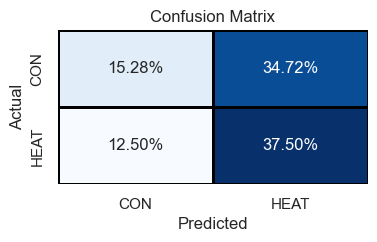

In [64]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

### Random Forest

In [66]:
%%time
rf_clf = RandomForestClassifier()

rf_clf.fit(xdata_sca, ydata)

CPU times: user 84.4 ms, sys: 3.93 ms, total: 88.4 ms
Wall time: 87.3 ms


RandomForestClassifier()

In [69]:
%%time
xtest_sca = sca.transform(xtest)
ypred = rf_clf.predict(xtest_sca)

CPU times: user 131 ms, sys: 6.9 ms, total: 137 ms
Wall time: 136 ms


              precision    recall  f1-score   support

         CON       0.62      0.50      0.55        36
        HEAT       0.58      0.69      0.63        36

    accuracy                           0.60        72
   macro avg       0.60      0.60      0.59        72
weighted avg       0.60      0.60      0.59        72



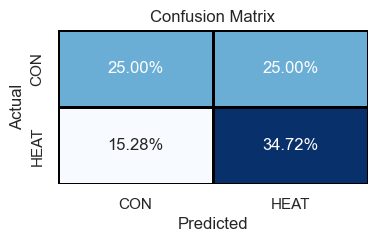

In [70]:
_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

# Feature Reduction

In [18]:
pca = PCA()

In [19]:
%%time
pcaData = data.iloc[:, :-1]
pca.fit(pcaData)

CPU times: user 2.31 s, sys: 263 ms, total: 2.57 s
Wall time: 519 ms


PCA()

In [20]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

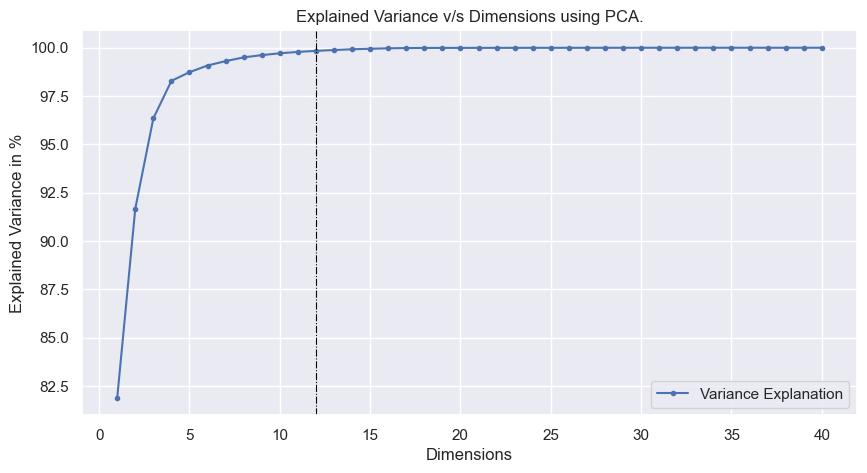

In [21]:
plt.figure(figsize=(10,5), dpi = 100)
plt.plot(range(1, len(cumsum)+1),cumsum*100,'.-', label='Variance Explanation')
plt.legend()
plt.axvline(12, ls='-.', c='black', lw=0.8)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance in %")
plt.title("Explained Variance v/s Dimensions using PCA.")
plt.show()

## PCA Features

In [41]:
pca = PCA(n_components=12)

In [73]:
%%time
pcaData = dataModelBC.iloc[:, :-1]
xdataPCA = pca.fit_transform(pcaData)

CPU times: user 12.8 s, sys: 2.95 s, total: 15.7 s
Wall time: 2.17 s


In [74]:
xdataPCA.shape

(16, 12)

### Logistic Regression

In [75]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xdataPCA, ydata)

CPU times: user 9.58 ms, sys: 3.03 ms, total: 12.6 ms
Wall time: 10.1 ms


LogisticRegression(random_state=32)

In [76]:
%%time
# xtest, ytest 
xtest_sca = pca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

CPU times: user 146 ms, sys: 5.32 ms, total: 151 ms
Wall time: 130 ms


              precision    recall  f1-score   support

         CON       0.80      0.67      0.73        36
        HEAT       0.71      0.83      0.77        36

    accuracy                           0.75        72
   macro avg       0.76      0.75      0.75        72
weighted avg       0.76      0.75      0.75        72



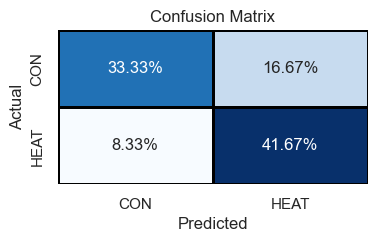

In [77]:
_ = resultAnalysisFnx(ytest, ypred[::-1], target_names=['CON', 'HEAT'])

### SVM

In [79]:
%%time
# Linear Kernel
svm_clf = SVC(kernel='linear')
svm_clf.fit(xdataPCA, ydata)

CPU times: user 3.13 ms, sys: 378 µs, total: 3.51 ms
Wall time: 3.23 ms


SVC(kernel='linear')

In [81]:
%%time
xtest_sca = pca.transform(xtest)
ypred = svm_clf.predict(xtest_sca)

CPU times: user 134 ms, sys: 5.66 ms, total: 140 ms
Wall time: 131 ms


              precision    recall  f1-score   support

         CON       0.94      0.42      0.58        36
        HEAT       0.62      0.97      0.76        36

    accuracy                           0.69        72
   macro avg       0.78      0.69      0.67        72
weighted avg       0.78      0.69      0.67        72



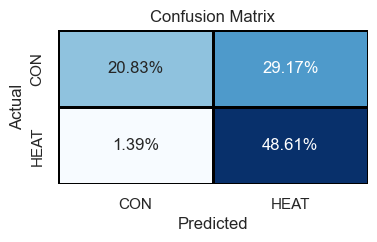

In [82]:
_ = resultAnalysisFnx(ytest, ypred[::-1], target_names=['CON', 'HEAT'])

## Recursive Function Elimination

In [192]:
%%time
# Retraining Model on entire USDA data but just for control and heat groups

dataModel = data.loc[:,commonFeaturesUMD+['tank']].copy()
dataModelBC = dataModel[(dataModel['tank'] == 'con') | (dataModel['tank'] == 'ht')]
dataModelBC.loc[:,:] = dataModelBC.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})
xdata, ydata = dataModelBC.loc[:, commonFeaturesUMD], dataModelBC.iloc[:,-1]
ydata = np.array(ydata.astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

# Testing on UMD data
xtest, ytest = dataUMD.loc[:, commonFeaturesUMD], dataUMD.iloc[:, 0]

CPU times: user 1.94 s, sys: 30.9 ms, total: 1.97 s
Wall time: 2 s


In [170]:
%%time
logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)

selector = RFE(logRes_clf, n_features_to_select=100, step=0.05, verbose = 1)

selector.fit(xdata_sca, np.array(ydata).astype(int))

Fitting estimator with 49378 features.
Fitting estimator with 46910 features.
Fitting estimator with 44442 features.
Fitting estimator with 41974 features.
Fitting estimator with 39506 features.
Fitting estimator with 37038 features.
Fitting estimator with 34570 features.
Fitting estimator with 32102 features.
Fitting estimator with 29634 features.
Fitting estimator with 27166 features.
Fitting estimator with 24698 features.
Fitting estimator with 22230 features.
Fitting estimator with 19762 features.
Fitting estimator with 17294 features.
Fitting estimator with 14826 features.
Fitting estimator with 12358 features.
Fitting estimator with 9890 features.
Fitting estimator with 7422 features.
Fitting estimator with 4954 features.
Fitting estimator with 2486 features.
CPU times: user 4.52 s, sys: 27.6 ms, total: 4.55 s
Wall time: 4.55 s


RFE(estimator=LogisticRegression(C=0.21, l1_ratio=0.5, penalty='elasticnet',
                                 random_state=32, solver='saga'),
    n_features_to_select=100, step=0.05, verbose=1)

              precision    recall  f1-score   support

         CON       0.70      0.86      0.78        36
        HEAT       0.82      0.64      0.72        36

    accuracy                           0.75        72
   macro avg       0.76      0.75      0.75        72
weighted avg       0.76      0.75      0.75        72



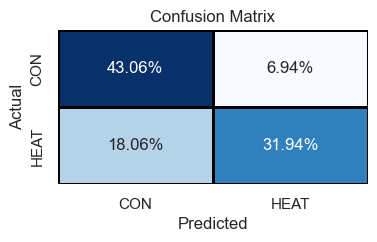

CPU times: user 677 ms, sys: 312 ms, total: 988 ms
Wall time: 607 ms


In [171]:
%%time
logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)
logRes_clf.fit(xdata_sca, ydata.astype(int))

xtest_sca = sca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

In [196]:
# feature_importance = selector.ranking_

# tt = np.argsort(feature_importance)[:250]
# expFeatures = tempColHolder[tt].tolist()

In [197]:
expFeatures = xdata.columns[selector.support_].tolist()

In [200]:
%%time
# Retraining Model on entire USDA data but just for control and heat groups

dataModel = data.loc[:,expFeatures+['tank']].copy()
dataModelBC = dataModel[(dataModel['tank'] == 'con') | (dataModel['tank'] == 'ht')]
dataModelBC.loc[:,:] = dataModelBC.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})
xdata, ydata = dataModelBC.loc[:, expFeatures], dataModelBC.iloc[:,-1]
ydata = np.array(ydata.astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

# Testing on UMD data
xtest, ytest = dataUMD.loc[:, expFeatures], dataUMD.iloc[:, 0]

CPU times: user 19.2 ms, sys: 2.36 ms, total: 21.6 ms
Wall time: 19.5 ms


              precision    recall  f1-score   support

         CON       0.50      1.00      0.67        36
        HEAT       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



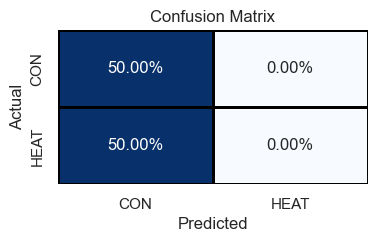

CPU times: user 111 ms, sys: 5.66 ms, total: 116 ms
Wall time: 70.9 ms


In [201]:
%%time
logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)
logRes_clf.fit(xdata_sca, ydata.astype(int))

xtest_sca = sca.transform(xtest)
ypred = logRes_clf.predict(xtest_sca)

_ = resultAnalysisFnx(ytest, ypred, target_names=['CON', 'HEAT'])

## Mutual Information

In [29]:
%%time
# Mutual Information
mi = mutual_info_classif(xdata, ydata)

CPU times: user 3min 13s, sys: 1min 29s, total: 4min 42s
Wall time: 39.4 s


In [30]:
featureScoresMIBC = pd.DataFrame({"feature":xdata.columns, "score":mi})
featureScoresMIBC.sort_values(by='score', ascending=False, inplace=True)

featureScoresMIBC.to_csv("./miFeatureScoreBC.csv", index=False)

In [31]:
# featureScoresMIBC
# featureScoresMI = pd.read_csv('./miFeatureScore.csv')

In [40]:
featureScoresMIBC['score'].describe(percentiles=[.01, .05, .075, 0.25, .999])

count    49378.000000
mean         0.077407
std          0.098090
min          0.000000
1%           0.000000
5%           0.000000
7.5%         0.000000
25%          0.000000
50%          0.036533
99.9%        0.533064
max          0.652207
Name: score, dtype: float64

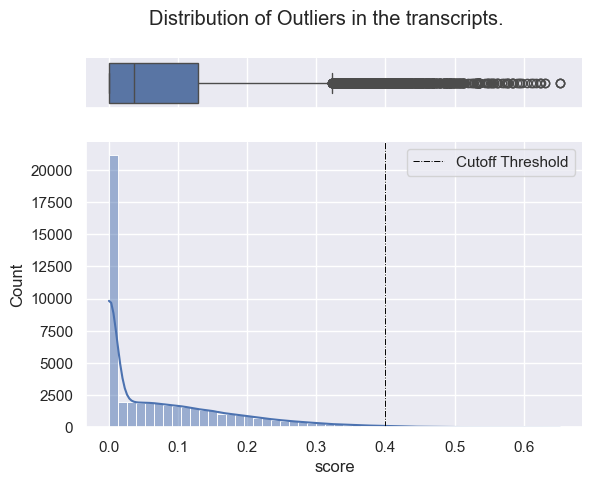

In [51]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(featureScoresMIBC['score'], ax=ax_box, orient='h')
sns.histplot(featureScoresMIBC['score'],bins=50, kde=True, ax=ax_hist)
ax_hist.axvline(0.4,c='black',ls='-.', lw=0.7, label='Cutoff Threshold')
plt.legend()

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of Outliers in the transcripts.")
plt.show()

In [52]:
featureScoresMIBC[featureScoresMIBC['score']>0.4]

,feature,score
24150,mast2_6,0.652207
14415,LOC110529917_1,0.652207
17929,LOC110489704_3,0.652207
14130,LOC110498654_2,0.631374
38281,agr2_2,0.631374
...,...,...
5504,LOC110510025_3,0.400524
7030,LOC100136088_1,0.400397
20453,LOC110527584_1,0.400370
2895,LOC110497390_2,0.400370


In [83]:
expFeatures = featureScoresMIBC[featureScoresMIBC['score']>0.4]['feature']

In [ ]:
%%time
# Retraining Model on entire USDA data but just for control and heat groups

dataModel = data.loc[:,commonFeaturesUMD+['tank']].copy()
dataModelBC = dataModel[(dataModel['tank'] == 'con') | (dataModel['tank'] == 'ht')]
dataModelBC.loc[:,:] = dataModelBC.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})
xdata, ydata = dataModelBC.loc[:, commonFeaturesUMD], dataModelBC.iloc[:,-1]
ydata = np.array(ydata.astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

# Testing on UMD data
xtest, ytest = dataUMD.loc[:, commonFeaturesUMD], dataUMD.iloc[:, 0]